In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.layers import Conv1D, Conv2D, Dense, Input, Concatenate, Reshape, Lambda
from keras.utils import plot_model
from scipy import stats as ss
from scipy import optimize
from scipy.interpolate import griddata
from IPython.display import Image, display

Using TensorFlow backend.


In [2]:
def create_model_1d(n_samples, out_dense_1, out_dense_2, depth, kernel_size, n_kernels):        
    # Number of neurons for the dense layers.
    n_channels = int(np.ceil((n_samples + kernel_size) / out_dense_2))
    
    # Shape of the output of the dense layers.
    out_dense_total = n_channels * out_dense_2
    
    # Adjusts the kernel size to fit with the previously calculated parameters.
    kernel_size = out_dense_total - n_samples + 1

    print("out_dense_1:", out_dense_1, "\nout_dense_2:", out_dense_2, "\nn_channels:",
          n_channels, "\nout_dense_total:", out_dense_total, "\nkernel_size:", kernel_size,
          "\nn_kernels:", n_kernels)
    
    # Model input.
    model = Input(shape=(2,), name='input')
    print("Shape after input:", model.shape)

    # Create the first two (dense) layers.
    layer_1 = []
    layer_2 = []
    reshape = []
    
    for i in range(n_channels):
        layer_1.append(Dense(out_dense_1 * depth, activation='relu', name='layer_1_{:02d}'.format(i))(model))
        layer_2.append(Dense(out_dense_2 * depth, activation='relu', name='layer_2_{:02d}'.format(i))(layer_1[-1]))
        reshape.append(Reshape(target_shape=(out_dense_2, depth))(layer_2[-1]))
    
    concat = Concatenate(axis=-1)(reshape)
    print("Shape after concat:", concat.shape)

    reshape = Reshape(target_shape=(out_dense_total, depth))(concat)
    print("Shape after reshape:", reshape.shape)
    
    conv = Conv1D(filters=n_kernels, kernel_size=kernel_size, strides=1)(reshape)
    
    avg = Lambda(lambda x: K.sum(x, axis=2), output_shape=lambda s: (s[0], s[1]))(conv)
    print("Shape after avg:", avg.shape)
    
    model = keras.Model(model, avg)
    
    plot_model(model, show_shapes=True, to_file='model.png')
    display(Image(retina=True, filename='model.png'))
    
    return model

In [3]:
def create_model_2d(n_samples, out_dense_1, out_dense_2, depth, kernel_size, n_kernels):        
    # Number of neurons for the dense layers.
    n_channels = int(np.ceil((n_samples + kernel_size) / out_dense_2))
    
    # Shape of the output of the dense layers.
    out_dense_total = n_channels * out_dense_2
    
    # Adjusts the kernel size to fit with the previously calculated parameters.
    kernel_size = out_dense_total - n_samples + 1

    print("out_dense_1:", out_dense_1, "\nout_dense_2:", out_dense_2, "\nn_channels:",
          n_channels, "\nout_dense_total:", out_dense_total, "\nkernel_size:", kernel_size,
          "\nn_kernels:", n_kernels)
    
    # Model input.
    model = Input(shape=(2,), name='input')
    print("Shape after input:", model.shape)

    # Create the first two (dense) layers.
    layer_1 = []
    layer_2 = []
    reshape = []
    
    for i in range(n_channels):
        layer_1.append(Dense(out_dense_1 * depth, activation='relu', name='layer_1_{:02d}'.format(i))(model))
        layer_2.append(Dense(out_dense_2 * depth, activation='relu', name='layer_2_{:02d}'.format(i))(layer_1[-1]))
        reshape.append(Reshape(target_shape=(out_dense_2, depth, 1))(layer_2[-1]))
    
    concat = Concatenate(axis=-1)(reshape)
    print("Shape after concat:", concat.shape)

    reshape = Reshape(target_shape=(out_dense_total, depth, 1))(concat)
    print("Shape after reshape:", reshape.shape)
    
    conv = Conv2D(filters=n_kernels, kernel_size=(kernel_size, depth), strides=1)(reshape)
    
    avg = Lambda(lambda x: K.sum(x, axis=-1), output_shape=lambda s: (s[0], s[1]))(conv)
    print("Shape after avg:", avg.shape)
    
    reshape_after_avg = Reshape(target_shape=(n_samples,))(avg)
    print("Shape after reshape:", reshape.shape)    
    
    model = keras.Model(model, reshape_after_avg)
    
    plot_model(model, show_shapes=True, to_file='model.png')
    display(Image(retina=True, filename='model.png'))
    
    return model

In [15]:
def gen_data(n_data, n_samples):
    mu = ss.uniform(MIN_MU, MAX_MU - MIN_MU).rvs(n_data) # ND 0, 2.5
    sd = ss.uniform(MIN_SD, MAX_SD - MIN_SD).rvs(n_data)
    x = np.linspace(MIN_X, MAX_X, n_samples) # Make sure that distributions don't get off the grid (truncated?)
    # TODO: Loss function plotting; allow for different loss functions.

    params = np.concatenate((mu[..., np.newaxis], sd[..., np.newaxis]), 1)
    x_sampled = ss.norm(mu[:, np.newaxis], sd[:, np.newaxis]).logpdf(x[np.newaxis, :])
    
    return params, x_sampled

In [31]:
# Define parameter range.
MIN_X, MAX_X = -10, 10
MIN_MU, MAX_MU = -3, 3
MIN_SD, MAX_SD = 0.5, 3

# Data settings.
N_DATA = 100000
N_SAMPLES = 150

# NN Settings.
OUT_D_1 = 10
OUT_D_2 = 40
DEPTH = 25
K_SIZE = 40
N_K = 15

out_dense_1: 10 
out_dense_2: 40 
n_channels: 5 
out_dense_total: 200 
kernel_size: 51 
n_kernels: 15
Shape after input: (?, 2)
Shape after concat: (?, 40, 25, 5)
Shape after reshape: (?, 200, 25, 1)
Shape after avg: (?, 150, 1)
Shape after reshape: (?, 200, 25, 1)


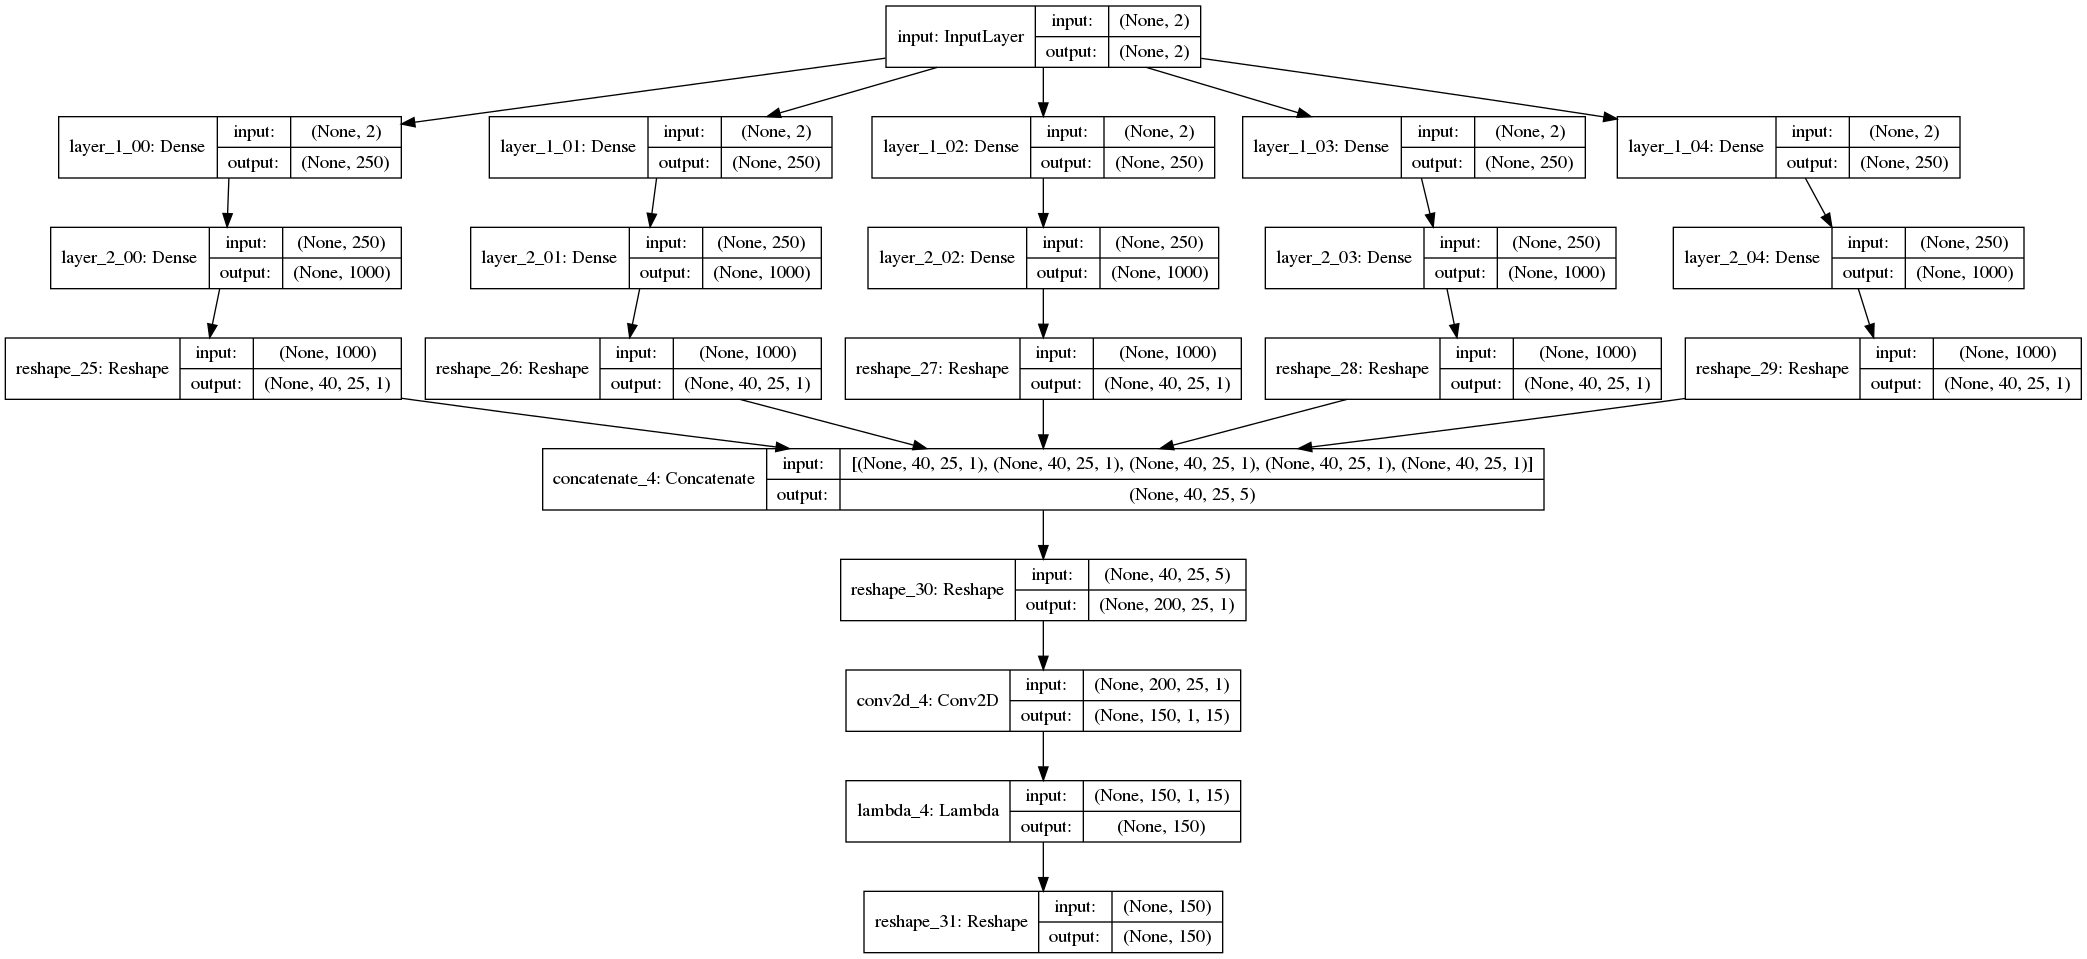

Epoch 1/3
100000/100000 [==============================] - 58s 579us/step - loss: 12.3678
Epoch 2/3
100000/100000 [==============================] - 57s 575us/step - loss: 0.4251
Epoch 3/3
100000/100000 [==============================] - 58s 576us/step - loss: 0.3914


In [32]:
model = create_model_2d(N_SAMPLES, OUT_D_1, OUT_D_2, DEPTH, K_SIZE, N_K)
model.compile(optimizer='adam', loss='mean_squared_error')

params, x_sampled = gen_data(N_DATA, N_SAMPLES)
model.fit(params, x_sampled, shuffle=True, batch_size=32, epochs=3)

In [33]:
predictions = model.predict(params)

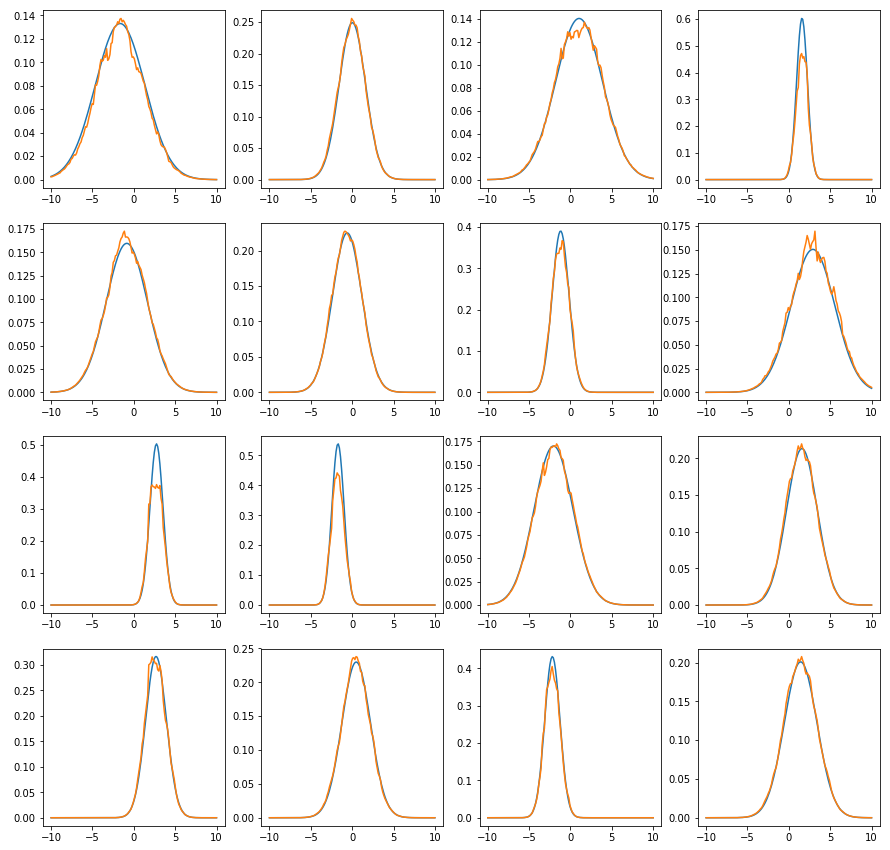

In [34]:
plt.figure(figsize=(15, 15))

for i, ix in enumerate(np.linspace(0, len(predictions), 16, dtype=int, endpoint=False)):
    plt.subplot(4, 4, i + 1)
    
    plt.plot(np.linspace(MIN_X, MAX_X, N_SAMPLES), np.exp(x_sampled[ix, :]))
    plt.plot(np.linspace(MIN_X, MAX_X, N_SAMPLES), np.exp(predictions[ix, :]))

In [36]:
# Log likelihood function.
def log_likelihood(model, params, points, xi):    
    #if (mu < -3) or (mu > 3): # TODO Change this to 2d
        #return -1e9
    
    params = np.atleast_2d(params)
    likelihood_on_grid = model.predict(params).T
    
    points = np.atleast_2d(points).T

    ll = griddata(points, likelihood_on_grid, xi, fill_value=-1e9)
    
    return ll

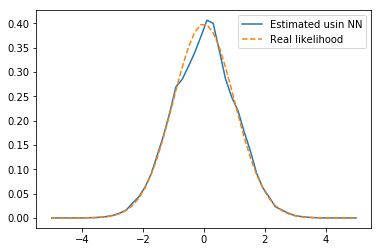

In [37]:
p = np.array([[0, 1]]) # Mean 0, SD 1.
pts = np.linspace(MIN_X, MAX_X, N_SAMPLES)
x_test = np.linspace(-5, 5)
ll = log_likelihood(model, p, pts, x_test)
    
plt.plot(x_test, np.exp(ll), label='Estimated usin NN')
plt.plot(x_test, ss.norm().pdf(x_test), ls='--', label='Real likelihood')
plt.legend()

In [38]:
def get_summed_ll(model, params, points, xi):
    return np.sum(log_likelihood(model, params, points, xi))

In [39]:
def estimate_mu(model, data, xi):
    
    return optimize.minimize(lambda x: -get_summed_ll(model, x, data, xi), 
                             x0=[0, 1], 
                             method='Nelder-Mead')

In [44]:
test_data = ss.norm(0).rvs(100)

In [45]:
estimate_mu(model, test_data, x_test).x[0]

-3.8766885340557407